# Download benchmarking data from S3 with Neuroglancer


#### This notebook explains how to:
(1) Read benchmarking data from S3 via Neuroglancer 

(2) download raw benchmarking data to your local computer 

#### Quick notes on the benchmarking data:

In octree format, data is labled in folders, labeled test_1 through test_25 and validation_1 through validation_25. 

If when downloading, you get a reshape error, try first uploading segments and then re-uploading the volumes. 

Known issues with a few of the files: 

- test_9,test_10 - didnt seem to have good swc alignment

- test_24 - issues with the image

- validation_11 - seems to be a shift between swcs and the image


##### Define locations

In [1]:
from brainlit.utils import session
from brainlit.utils.Neuron_trace import NeuronTrace

#Can change to test_"1-25", validation_"1-25"
dest = "s3://open-neurodata/brainlit/benchmarking_data/validation_7" 
dest_segments = "s3://open-neurodata/brainlit/benchmarking_data/validation_7"

c:\users\shrey\anaconda3\envs\ndd-windows\lib\site-packages\python_jsonschema_objects\__init__.py:53: UserWarning: Schema version http://json-schema.org/draft-04/schema not recognized. Some keywords and features may not be supported.
  self.schema["$schema"]


##### Create Neuroglancer session & download benchmarking volume

In [2]:
%%capture
sess = session.NeuroglancerSession(url=dest, url_segments=dest_segments, mip=0)  # create session object 
img, bounds, vertices = sess.pull_vertex_list(1, [1], 0, expand=True)  # get full benchmarking image

##### Download a specific .swc

In [3]:
seg_id = 1 # Can change

G_paths = sess.get_segments(seg_id, bounds, rounding = False)
G = G_paths[0]
paths = G_paths[1]

Downloading: 100%|████████████████████████████████████| 1/1 [00:00<00:00, 14.56it/s]


##### Visualize with napari

In [16]:
import napari
from napari.utils import nbscreenshot

viewer = napari.Viewer(ndisplay=3)
viewer.add_image(img)
viewer.add_shapes(data=paths, shape_type='path', edge_width=1.0, edge_color='blue', opacity=0.8)

<Shapes layer 'paths' at 0x23733145b48>

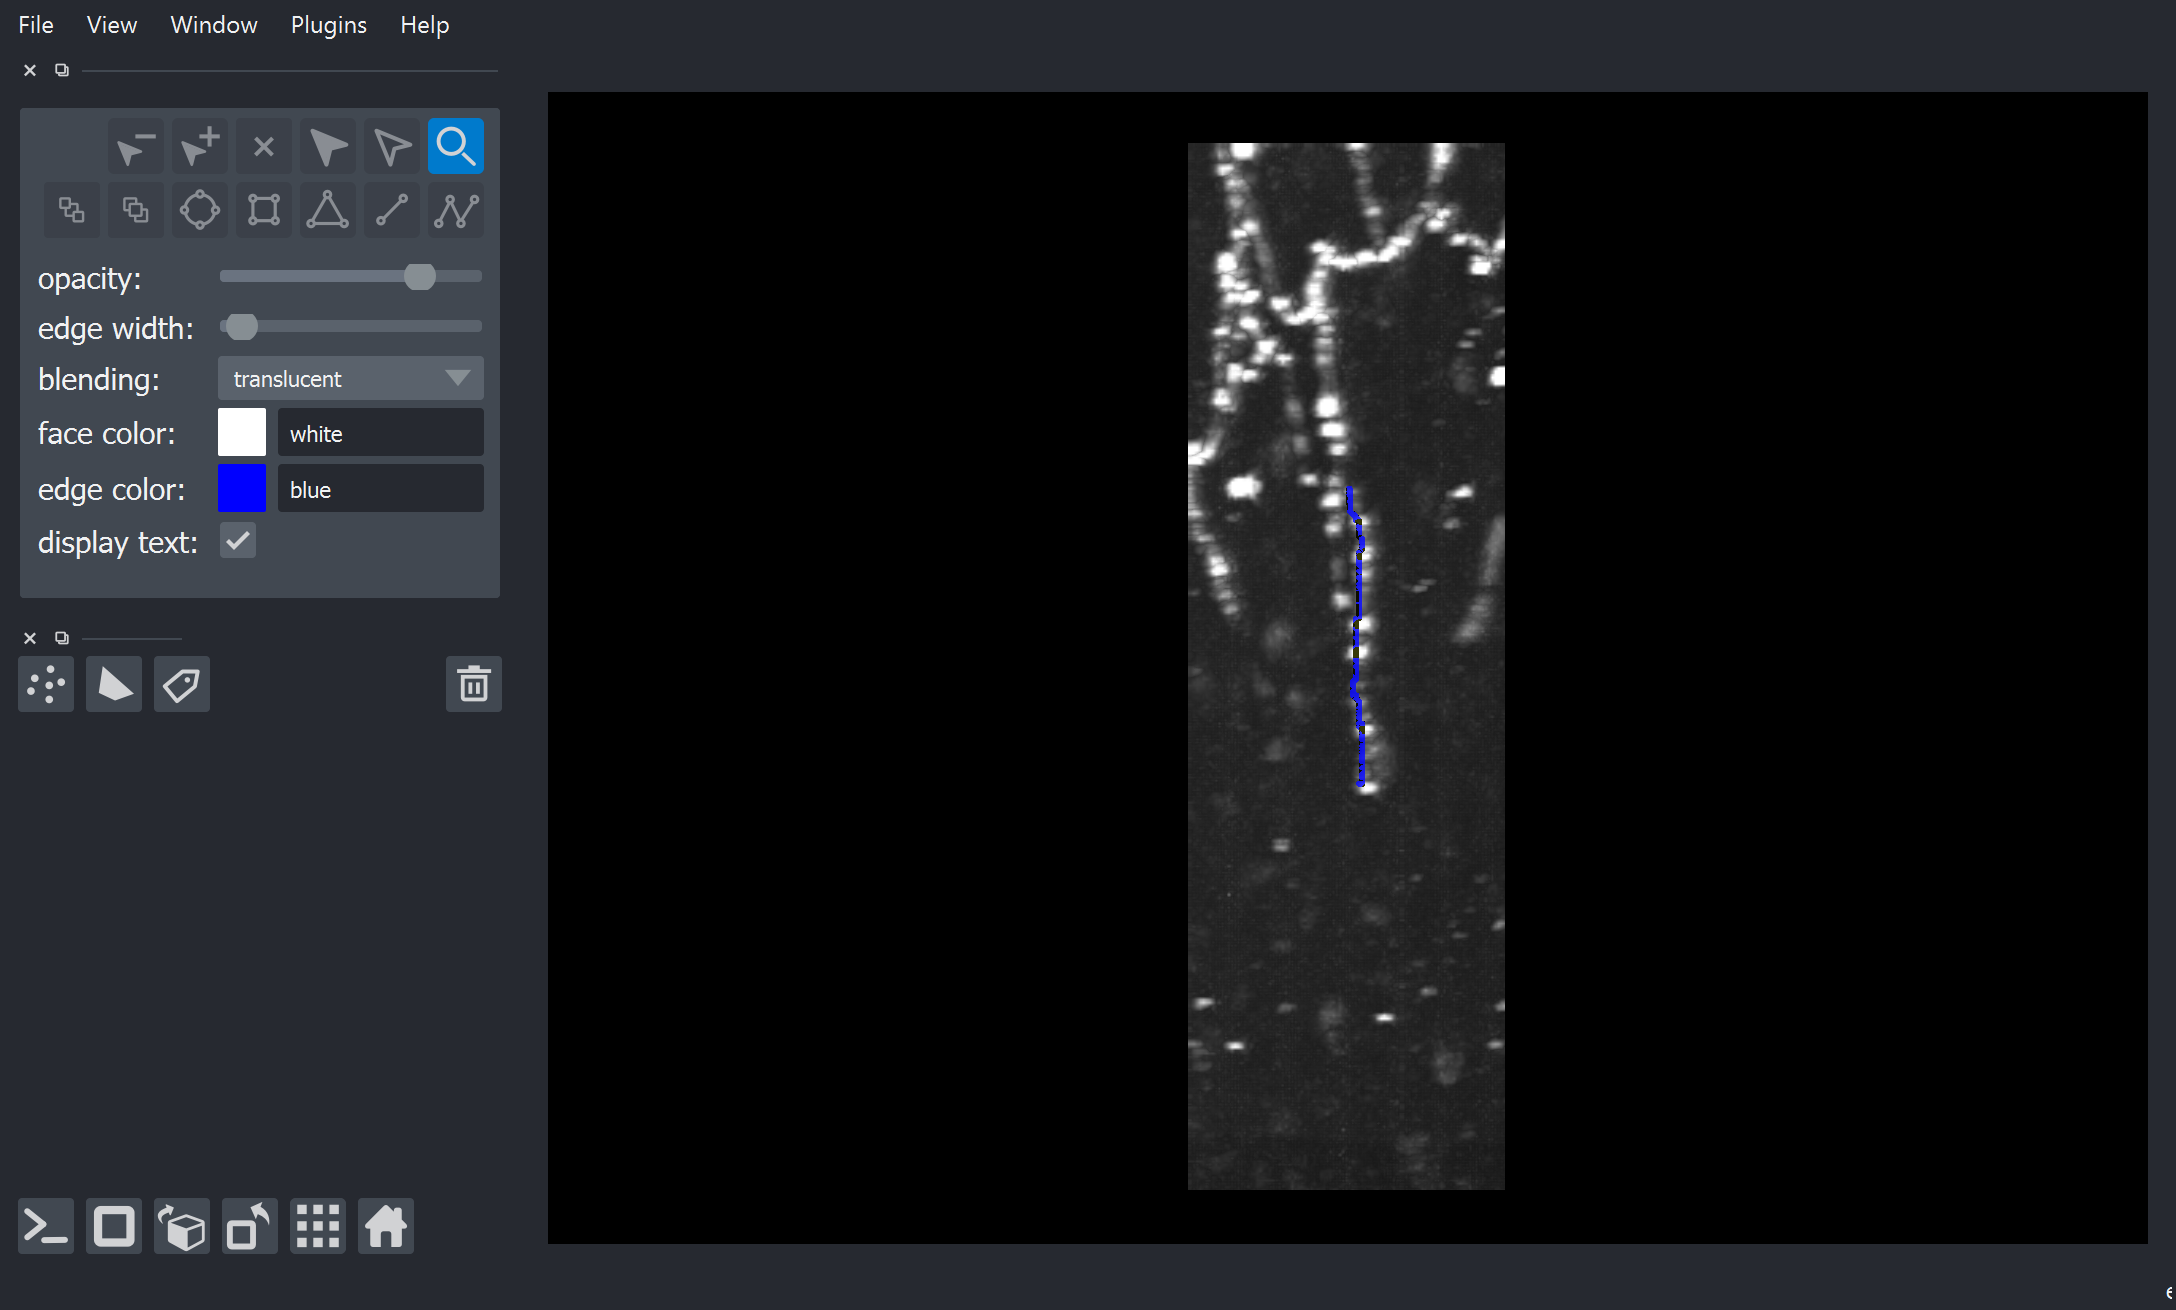

In [17]:
nbscreenshot(viewer)

# Download RAW benchmarking data

###### This will download the benchmarking data in .tif and .swc format to a local destination

In [18]:
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import os
from pathlib import Path
import numpy as np
from skimage import io
from tqdm import tqdm

## Create directories

In [19]:
cwd = Path(os.path.abspath(''))
data_dir = os.path.join(cwd, "data")
print(f"Downloading segments to {data_dir}")
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

im_dir = os.path.join(data_dir, "sample-tif-location")
if not os.path.exists(im_dir):
    os.makedirs(im_dir)

swc_dir = os.path.join(data_dir, "sample-swc-location")
if not os.path.exists(swc_dir):
    os.makedirs(swc_dir)

### Accessing .tif files

On mac/linux, we use os.path.join to construct the s3 path. However on windows you should set prefix to "brainlit/benchmarking_data/tif-files"

In [20]:
s3 = boto3.resource("s3", config=Config(signature_version=UNSIGNED))
bucket = s3.Bucket("open-neurodata")
prefix = "brainlit/benchmarking_data/tif-files" #use this for windows
#prefix = os.path.join("brainlit", "benchmarking_data", "tif-files") #use this for linux/mac
im_count = 0
for _ in bucket.objects.filter(Prefix=prefix):
    im_count += 1
for i, im_obj in enumerate(tqdm(bucket.objects.filter(Prefix=prefix))):
    if im_obj.key[-4:] == '.tif':
        im_name = os.path.basename(im_obj.key)
        im_path = os.path.join(im_dir, im_name)
        bucket.download_file(im_obj.key, im_path)

52it [02:02,  2.36s/it]


The below code can visualize a specified .tif file.

In [23]:
import napari
from napari.utils import nbscreenshot

file_name = "test_10-gfp.tif" # Can change to any image (test 1-25, validation 1-25)

im_file = Path(im_dir) / file_name
im = io.imread(im_file, plugin="tifffile") 
    
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(im)

<Image layer 'im' at 0x23733352fc8>

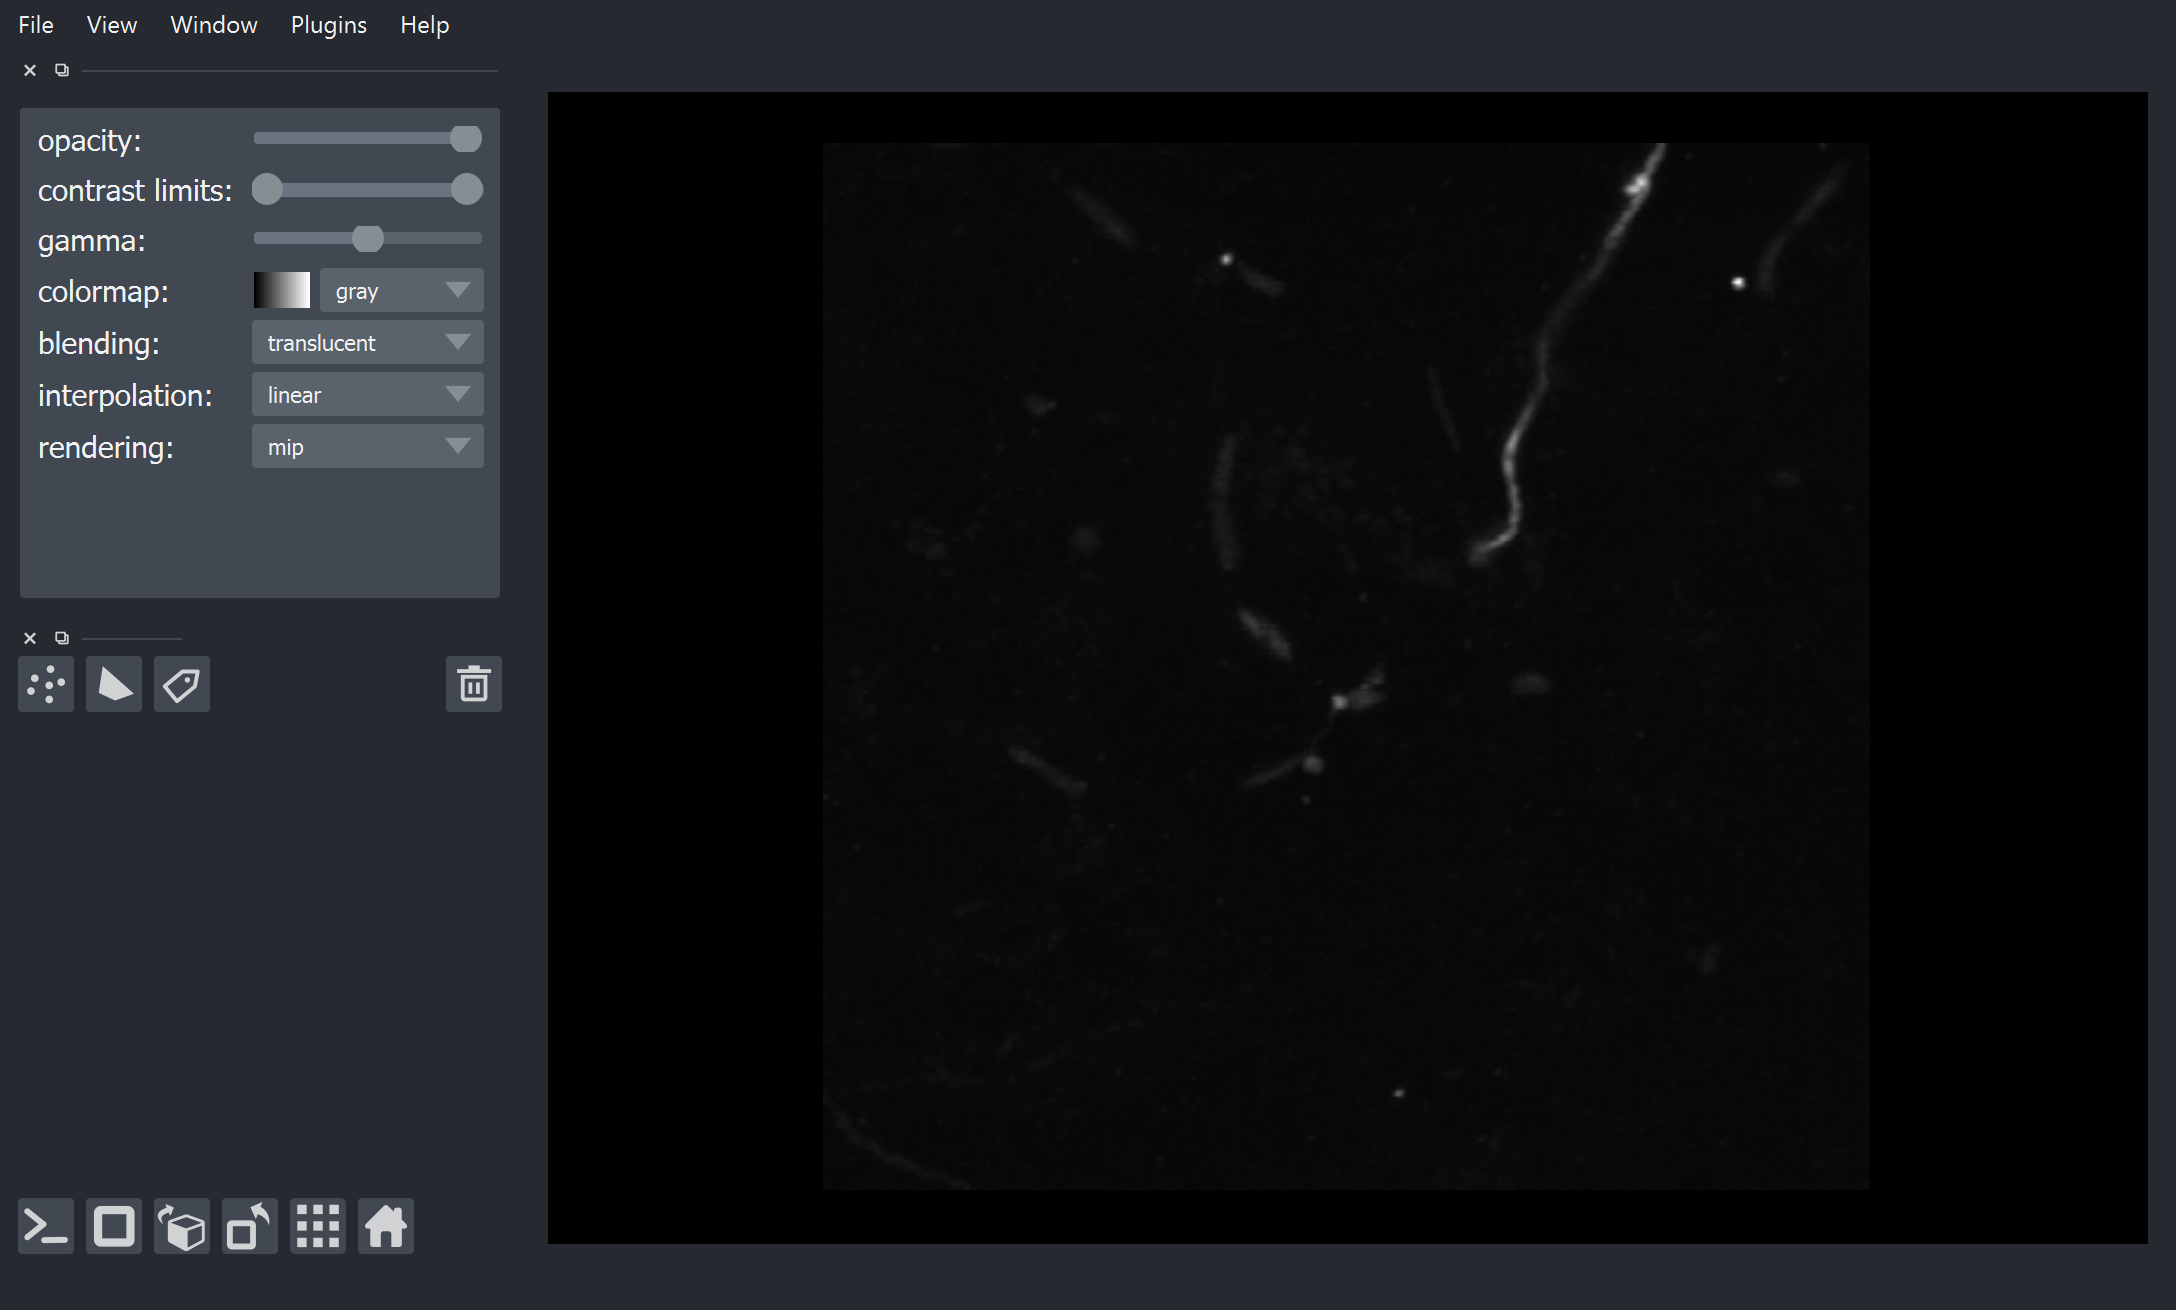

In [24]:
nbscreenshot(viewer)

### Accessing .swc files

Again, on windows you need to make the variable called prefix a string

In [25]:
s3 = boto3.resource("s3", config=Config(signature_version=UNSIGNED))
bucket = s3.Bucket("open-neurodata")
prefix = "brainlit/benchmarking_data/Manual-GT" #use this for windows
#prefix = os.path.join("brainlit", "benchmarking_data", "Manual-GT") #use this for linux/mac
swc_count = 0
for _ in bucket.objects.filter(Prefix=prefix):
    swc_count += 1
for i, swc_obj in enumerate(tqdm(bucket.objects.filter(Prefix=prefix))):
    if swc_obj.key[-4:] == '.swc':
        idx = swc_obj.key.find('Manual-GT')
        swc_name = swc_obj.key[idx:]
        swc_path = os.path.join(swc_dir, swc_name)
        dir = os.path.dirname(swc_path)
        if not os.path.exists(dir):
            os.makedirs(dir)
        bucket.download_file(swc_obj.key, swc_path)

601it [02:01,  4.93it/s]


### Aligning and visualizing images & swcs

In [26]:
from brainlit.utils.benchmarking_params import brain_offsets, vol_offsets, scales, type_to_date
from brainlit.utils.Neuron_trace import NeuronTrace
from pathlib import Path
import numpy as np
from skimage import io
import napari
from napari.utils import nbscreenshot

In [27]:
im_dir = Path(im_dir)
swc_base_path = Path(swc_dir) / "Manual-GT"

gfp_files = list(im_dir.glob("**/*-gfp.tif"))

In [30]:
for im_num, im_path in enumerate(gfp_files):
    
    print(f"Image {im_num+1}/{len(gfp_files)}")
    print(im_path)
    
    f = im_path.parts[-1][:-8].split("_")
    image = f[0]
    date = type_to_date[image]
    num = int(f[1])

    scale = scales[date]
    brain_offset = brain_offsets[date]
    vol_offset = vol_offsets[date][num]
    im_offset = np.add(brain_offset, vol_offset)

    lower = int(np.floor((num - 1) / 5) * 5 + 1)
    upper = int(np.floor((num - 1) / 5) * 5 + 5)
    dir1 = date + "_" + image + "_" + str(lower) + "-" + str(upper)
    dir2 = date + "_" + image + "_" + str(num)
    swc_path = swc_base_path / dir1 / dir2
    swc_files = list(swc_path.glob("**/*.swc"))
    im = io.imread(im_path, plugin="tifffile")
    print(f"Image shape: {im.shape}")

    paths_total = []
    for swc_num, swc in enumerate(swc_files):
        if "0" in swc.parts[-1]:
            # skip the bounding box swc
            continue

        swc_trace = NeuronTrace(path=str(swc))
        paths = swc_trace.get_paths()
        swc_offset, _, _, _ = swc_trace.get_df_arguments()
        offset_diff = np.subtract(swc_offset, im_offset)
       
        for path_num, p in enumerate(paths):
            pvox = (p + offset_diff) / (scale) * 1000
            paths_total.append(pvox)
            
    #with napari.gui_qt():
    viewer = napari.Viewer(ndisplay=3)
    viewer.add_image(np.swapaxes(im,0,2))
    viewer.add_shapes(data=paths_total, shape_type='path', edge_width=1.0, edge_color='blue', opacity=0.8)
    break

Image 1/50
C:\Users\shrey\Documents\NDD\brainlit\docs\notebooks\utils\data\sample-tif-location\test_1-gfp.tif
Image shape: (100, 330, 330)


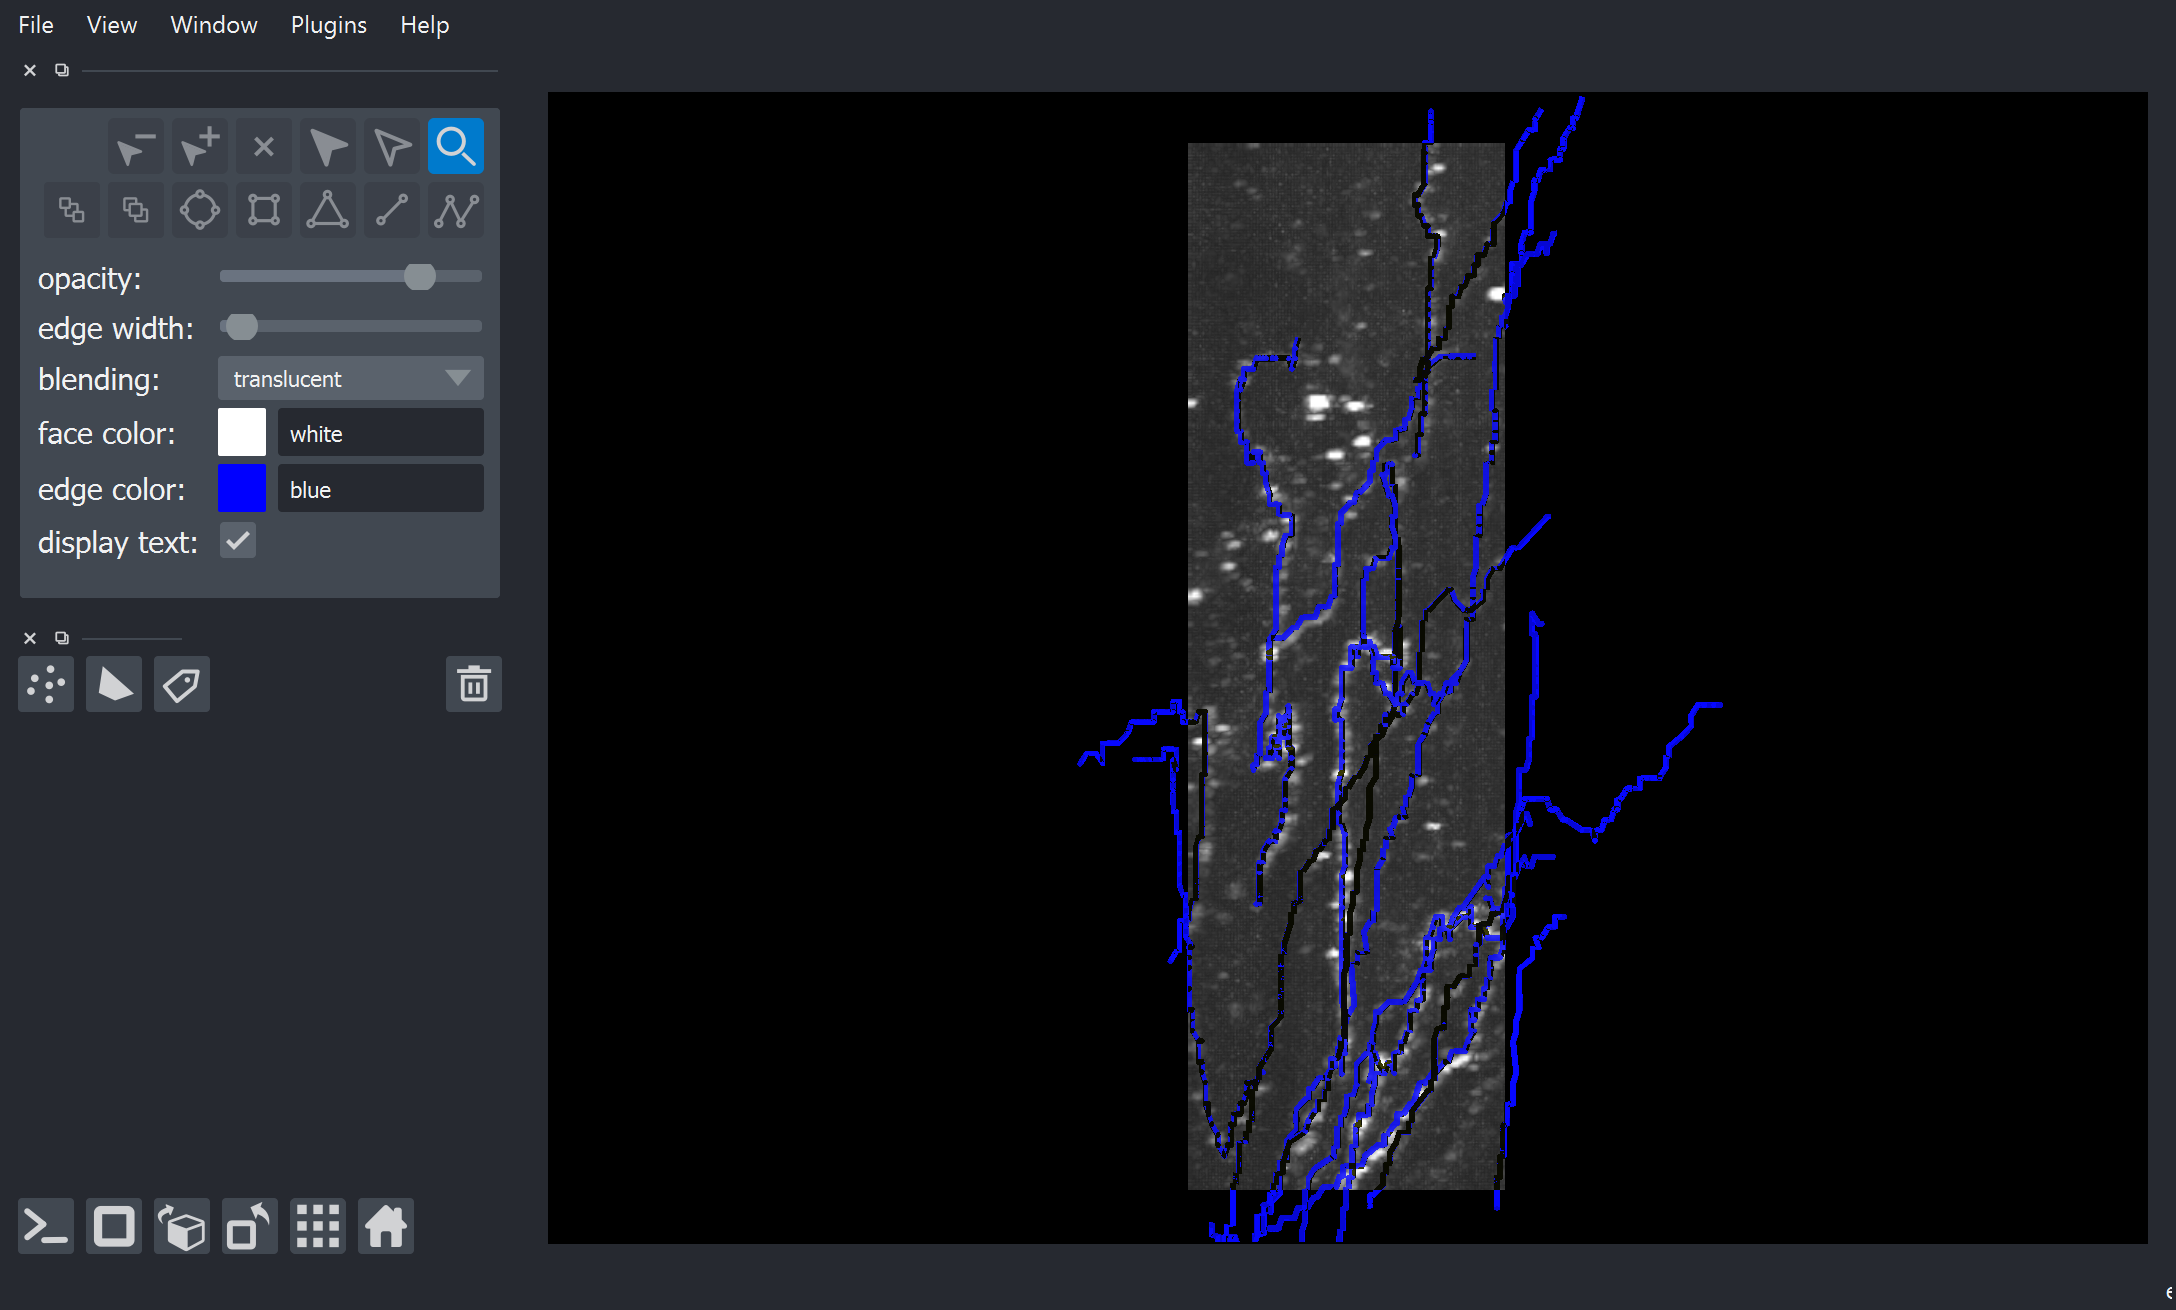

In [31]:
nbscreenshot(viewer)    